In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Data Loading

In [2]:
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')

In [3]:
X = data['Translated']
y = data['Label']

In [4]:
X

0      After hacking state TV by replacing propaganda...
1      #flowers #lovers\nMake love not war.\nMarc Cha...
2      If only we all showed more love and understand...
3      Who are the soldiers we see in the videos? Are...
4      I didn't think #Salvini could make his positio...
                             ...                        
475    If I write that Ms. #Zelensky was allegedly sp...
476    #Zelensky and his wife #OlenaZelenska bought a...
477    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
478    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
479    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
Name: Translated, Length: 480, dtype: object

In [5]:
y

0      1
1      2
2      2
3      2
4      1
      ..
475    1
476    0
477    2
478    2
479    2
Name: Label, Length: 480, dtype: int64

# Pretrained not Finetuned

## Load Bert

In [6]:
pretrained_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pretrained_model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Generate Embeddings

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.to(device)

def generate_sentence_embeddings(texts, tokenizer, model, batch_size=32):
    """
    Generate BERT embeddings for a list of sentences.

    Args:
        texts (list of str): List of input sentences.
        tokenizer: Pre-trained BERT tokenizer.
        model: Pre-trained BERT model.
        batch_size (int): Batch size for processing.
        device (str): Device to use ('cpu' or 'cuda').

    Returns:
        np.ndarray: Array of sentence embeddings (shape: [num_sentences, embedding_dim]).
    """
    model.to(device)
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            ).to(device)
            outputs = model(**inputs)
            pooled_output = outputs.pooler_output.cpu().numpy()
            embeddings.append(pooled_output)
    return np.vstack(embeddings)

In [9]:

# Split the data while preserving raw text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate embeddings for training and testing sets
print("Generating BERT embeddings...")
X_train_embeddings = generate_sentence_embeddings(X_train.tolist(), pretrained_tokenizer, pretrained_model)
X_test_embeddings = generate_sentence_embeddings(X_test.tolist(), pretrained_tokenizer, pretrained_model)

print('Done')

Generating BERT embeddings...


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Done


## Train an SVM

In [10]:
print("Training SVM...")
clf = SVC(kernel='linear')
clf.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Training SVM...
Accuracy: 41.67%


## View report

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.50      0.48        16
           1       0.17      0.20      0.18        20
           2       0.53      0.60      0.57        43
           3       0.33      0.12      0.17        17

    accuracy                           0.42        96
   macro avg       0.38      0.36      0.35        96
weighted avg       0.41      0.42      0.40        96



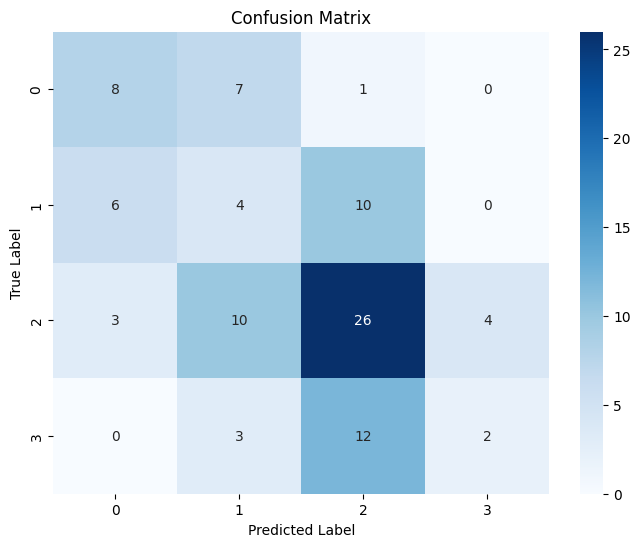

In [11]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get unique class labels for plotting
class_labels = sorted(set(y_test))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## See misclassified sentences

In [12]:
misclassified_indices = np.where(y_test != y_pred)[0]

# Print misclassified sentences
print("Misclassified Sentences:")
for idx in misclassified_indices:
    print()
    print(f"True Label: {y_test.iloc[idx]}, Predicted Label: {y_pred[idx]}, Sentence: {X_test.iloc[idx]}")
    print('---')

Misclassified Sentences:

True Label: 3, Predicted Label: 2, Sentence: From symbol of peace to megaphone for war, #Putin rewrites history of #Luzniki stadium
---

True Label: 1, Predicted Label: 2, Sentence: Countries supporting #Ukraine do not have the means to track the weapons they send to the Kiev army. And some have already gone to pro-Russian troops in the #Donbass, as some photos show 👇

by @FuturaDaprile

 
---

True Label: 1, Predicted Label: 0, Sentence: LA #GUERRA GIUSTA NON ESISTE!
INVOCARE #PACE INVIANDO #ARMI NON È PER L'EROE CHE COMBATTE, MA PER IL POPOLO CHE VIENE MACELLATO!
SIAMO UN PAESE DI COGLIONI INVASATI!
Sveglia!!!
#StopTheWar
#DraghiVatteneSubito
#NonInMioNome
---

True Label: 2, Predicted Label: 1, Sentence: This #April25 I will go to the parade.
I had the honor of knowing that generation of #Liberals who took up arms to defend the Fatherland, and I know they would have no problem today recognizing the #partisans of that time in the Ukrainians and Ukrainians of

## Visualize the embeddings of the individual words

In [13]:
def generate_word_embeddings(text, tokenizer, model, device='cpu'):

    model.to(device)
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state  # Shape: (1, num_tokens, 768)
        embeddings = hidden_states.squeeze(0).cpu().numpy()  # Shape: (num_tokens, 768)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    return tokens, embeddings

def plot_word_embeddings(tokens, embeddings, reduction_method='pca'):

    # Step 1: Reduce dimensions to 2D
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(5, len(tokens) - 1))
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    else:
        raise ValueError("Invalid reduction method. Choose 'pca' or 'tsne'.")

    # Step 2: Plot the embeddings
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', alpha=0.7)

    # Annotate each point with its token
    for i, token in enumerate(tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)

    plt.xlabel(f'{reduction_method.upper()} Component 1')
    plt.ylabel(f'{reduction_method.upper()} Component 2')
    plt.title(f'2D Word Embedding Visualization ({reduction_method.upper()})')
    plt.grid()
    plt.show()

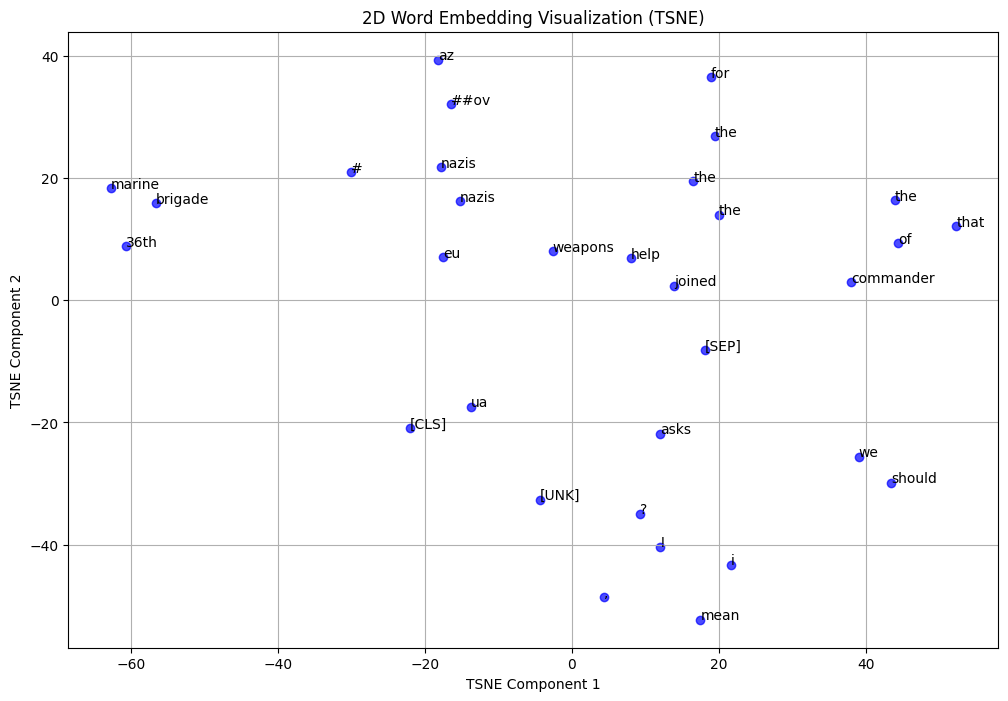

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
text = """UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""
tokens, embeddings = generate_word_embeddings(text, pretrained_tokenizer, pretrained_model, device=device)
plot_word_embeddings(tokens, embeddings, reduction_method='tsne')

## Visualize the Embeddings

In [15]:
def plot_attention_scores(sentence, tokenizer, model, device='cpu', layer=0, head=0):

    # Step 1: Move the model to the specified device
    model.to(device)
    model.eval()

    # Step 2: Tokenize the input sentence
    inputs = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )

    # Step 3: Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Step 4: Generate attention scores
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Tuple of attention tensors for all layers and heads

    # Step 5: Extract attention scores for the specified layer and head
    # Average attention scores across all heads in a layer
    attention_scores = attentions[layer].mean(dim=1)[0].cpu().numpy()
    
    # Average attention scores across all layers and heads
    attention_scores = torch.stack(attentions).mean(dim=(1, 2))[0].cpu().numpy()

    # Step 6: Get tokens for labeling
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Step 7: Plot attention scores as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_scores, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f"Attention Scores (Layer {layer}, Head {head})")
    plt.xlabel("Keys (Tokens)")
    plt.ylabel("Queries (Tokens)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

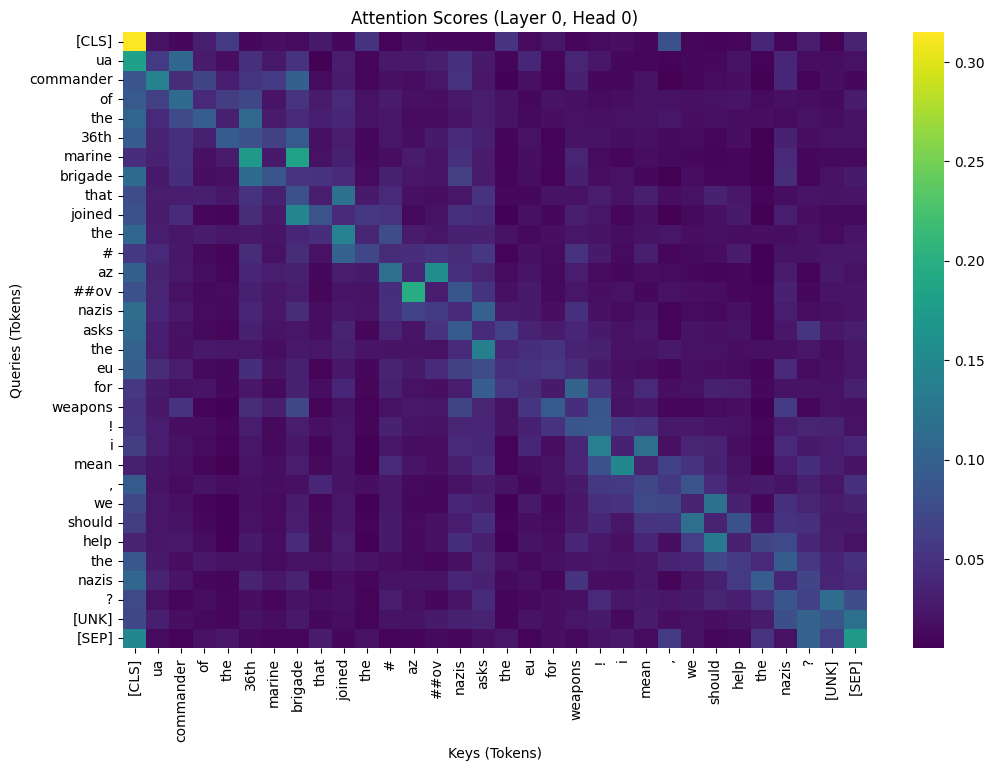

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sentence =""" UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""
plot_attention_scores(sentence, pretrained_tokenizer, pretrained_model, device=device, layer=0, head=0)

# Finetuning BERT

In [20]:
import numpy as np
import pandas as pd
import torch
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Load data
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')
X = data['Translated']
y = data['Label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)), output_attentions=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=self.max_length
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Fine-tune BERT
def train_model(model, train_loader, optimizer, scheduler, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
print("Fine-tuning BERT...")
train_model(model, train_loader, optimizer, scheduler, epochs = 25)

Fine-tuning BERT...
Epoch 1, Loss: 1.4123756339152653
Epoch 2, Loss: 1.400776798526446
Epoch 3, Loss: 1.3907185743252437
Epoch 4, Loss: 1.4003855933745701
Epoch 5, Loss: 1.3947964906692505
Epoch 6, Loss: 1.4076028366883595
Epoch 7, Loss: 1.4047011782725651
Epoch 8, Loss: 1.396109605828921
Epoch 9, Loss: 1.4005897839864094
Epoch 10, Loss: 1.4003666738669078
Epoch 11, Loss: 1.40757450958093
Epoch 12, Loss: 1.3988444209098816
Epoch 13, Loss: 1.395089328289032
Epoch 14, Loss: 1.398912673195203
Epoch 15, Loss: 1.4026007652282715
Epoch 16, Loss: 1.4060329149166744
Epoch 17, Loss: 1.3975346734126408
Epoch 18, Loss: 1.401440292596817
Epoch 19, Loss: 1.3909533868233364
Epoch 20, Loss: 1.4123041480779648
Epoch 21, Loss: 1.391734704375267
Epoch 22, Loss: 1.4005677451690037
Epoch 23, Loss: 1.403854101896286
Epoch 24, Loss: 1.3949031581481297
Epoch 25, Loss: 1.3995438814163208


In [12]:
# Generate embeddings from fine-tuned BERT
def generate_finetuned_embeddings(texts, tokenizer, model, batch_size=32):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            ).to(device)
            outputs = model.bert(**inputs)  # Use the BERT backbone
            pooled_output = outputs.pooler_output.cpu().numpy()
            embeddings.append(pooled_output)
    return np.vstack(embeddings)

Generating embeddings...
Training SVM...
Accuracy: 45.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.31      0.32        16
           1       0.39      0.28      0.33        25
           2       0.50      0.63      0.56        41
           3       0.55      0.43      0.48        14

    accuracy                           0.46        96
   macro avg       0.44      0.41      0.42        96
weighted avg       0.45      0.46      0.45        96



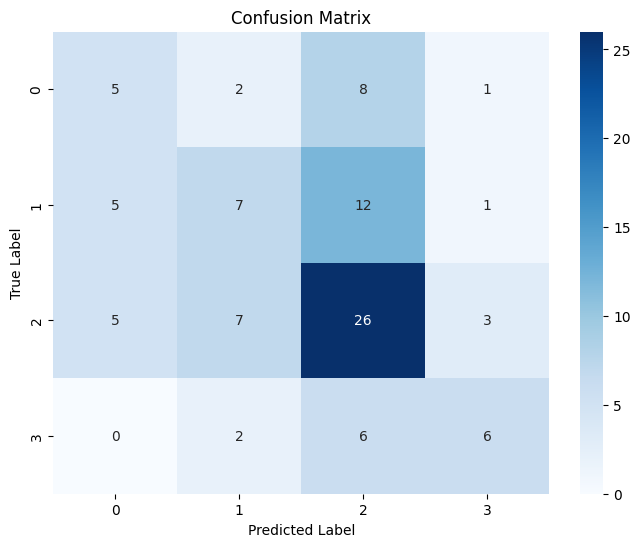

Misclassified Sentences:
True Label: 3, Predicted Label: 2, Sentence: Ukraine, Gb media: "Evacuation of 2,000 civilians from Mariupol underway" #war #Ukraine #UkraineRussianWar #russia #putin #Mariupol
True Label: 1, Predicted Label: 0, Sentence: LA #GUERRA GIUSTA NON ESISTE!
INVOCARE #PACE INVIANDO #ARMI NON È PER L'EROE CHE COMBATTE, MA PER IL POPOLO CHE VIENE MACELLATO!
SIAMO UN PAESE DI COGLIONI INVASATI!
Sveglia!!!
#StopTheWar
#DraghiVatteneSubito
#NonInMioNome
True Label: 2, Predicted Label: 0, Sentence: @BTwoEl @rusembitaly Troll look at this picture !
This is the result of your idol Putler aka Hitler aka Putin !
#FCKPTN
True Label: 2, Predicted Label: 1, Sentence: I may have all the flaws in the world but I am not a daughter of #putin I don't support his war in #Ukraine I don't buy his propaganda to invade other territories and seize raw materials. Down with the dictator, long live the resistance! #FreeUkraine #FCKPTN #PutinWarCriminal
True Label: 1, Predicted Label: 2, Sentenc

In [13]:
print("Generating embeddings...")
X_train_embeddings = generate_finetuned_embeddings(X_train.tolist(), tokenizer, model)
X_test_embeddings = generate_finetuned_embeddings(X_test.tolist(), tokenizer, model)

# Train SVM classifier
print("Training SVM...")
clf = SVC(kernel='linear')
clf.fit(X_train_embeddings, y_train)

# Evaluate SVM
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]

print("Misclassified Sentences:")
for idx in misclassified_indices:
    print(f"True Label: {y_test.iloc[idx]}, Predicted Label: {y_pred[idx]}, Sentence: {X_test.iloc[idx]}")

In [22]:
def generate_word_embeddings(text, tokenizer, model, device='cpu'):
    model.to(device)
    model.eval()
    
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model.bert(**inputs)  # Use the BERT backbone
        hidden_states = outputs.last_hidden_state  # Shape: (1, num_tokens, 768)
        embeddings = hidden_states.squeeze(0).cpu().numpy()  # Shape: (num_tokens, 768)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    return tokens, embeddings

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_word_embeddings(tokens, embeddings, reduction_method='pca'):
    # Step 1: Reduce dimensions to 2D
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(5, len(tokens) - 1))
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    else:
        raise ValueError("Invalid reduction method. Choose 'pca' or 'tsne'.")

    # Step 2: Plot the embeddings
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', alpha=0.7)

    # Annotate each point with its token
    for i, token in enumerate(tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)

    plt.xlabel(f'{reduction_method.upper()} Component 1')
    plt.ylabel(f'{reduction_method.upper()} Component 2')
    plt.title(f'2D Word Embedding Visualization ({reduction_method.upper()})')
    plt.grid()
    plt.show()

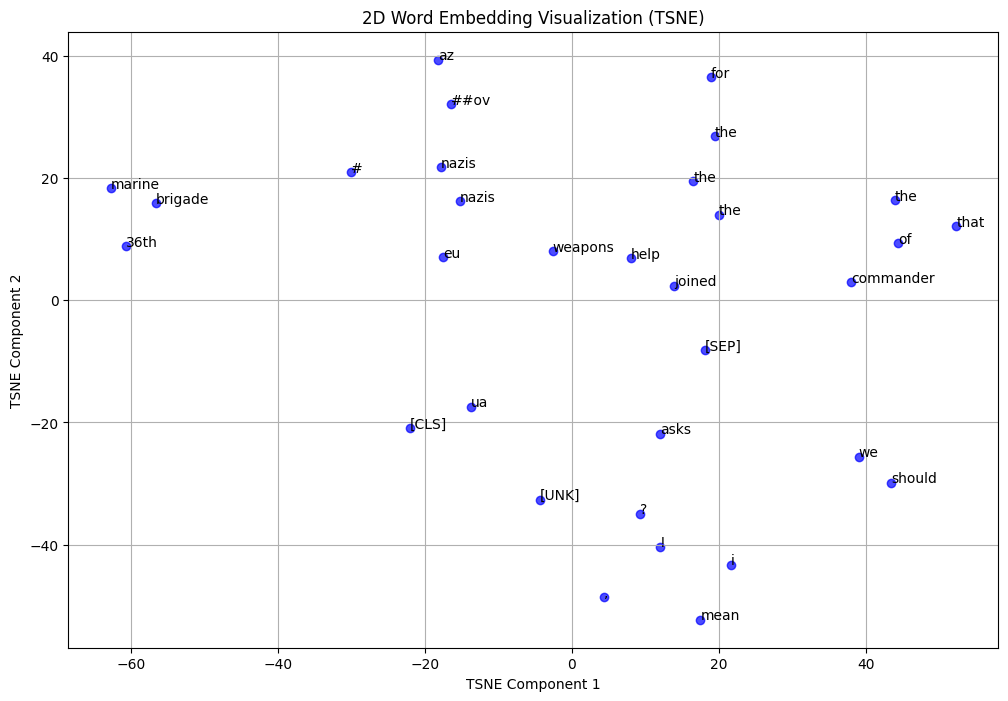

In [24]:
# Example sentence
sentence = """UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""

# Generate word embeddings
tokens, embeddings = generate_word_embeddings(sentence, tokenizer, model, device=device)

# Plot embeddings
plot_word_embeddings(tokens, embeddings, reduction_method='tsne')  # Use 'pca' or 'tsne'

In [25]:
def plot_attention_scores(sentence, tokenizer, model, device='cpu', layer=0, head=0):
    model.to(device)
    model.eval()

    # Tokenize the input sentence
    inputs = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate attention scores
    with torch.no_grad():
        outputs = model.bert(**inputs, output_attentions=True)
        attentions = outputs.attentions  # Tuple of attention tensors for all layers and heads

    # Extract attention scores for the specified layer and head
    attention_scores = attentions[layer][0, head].cpu().numpy()  # Shape: (num_tokens, num_tokens)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Plot attention scores as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_scores, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f"Attention Scores (Layer {layer}, Head {head})")
    plt.xlabel("Keys (Tokens)")
    plt.ylabel("Queries (Tokens)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

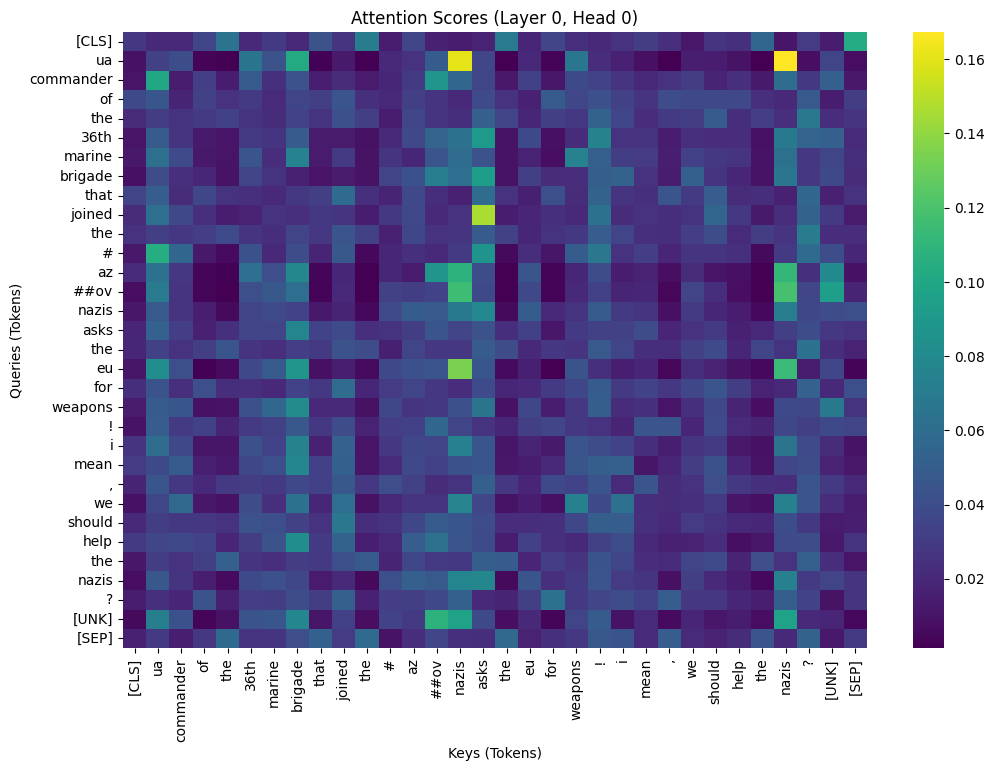

In [26]:
# Example sentence
sentence = """UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""
# Plot attention scores for Layer 0, Head 0
plot_attention_scores(sentence, tokenizer, model, device=device, layer=0, head=0)

# Tuning the Hyper Parameters

In [30]:
import numpy as np
import pandas as pd
import torch
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# Load data
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')
X = data['Translated']
y = data['Label']


In [48]:
# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)), output_attentions=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [49]:
# Define dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=self.max_length
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Create datasets
train_dataset = TextDataset(X_train_final.tolist(), y_train_final.tolist(), tokenizer)
val_dataset = TextDataset(X_val.tolist(), y_val.tolist(), tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [50]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pth'):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for saving the best model checkpoint.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [51]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, early_stopping, epochs=25):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

        # Call early stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

In [53]:
from transformers import BertForSequenceClassification, AdamW

# Initialize the model
hyperparam_finetuned_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(set(y))
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hyperparam_finetuned_model.to(device)

# Initialize optimizer and scheduler
optimizer = AdamW(hyperparam_finetuned_model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Initialize early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [54]:
print("Fine-tuning BERT...")
train_model(
    hyperparam_finetuned_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    early_stopping,
    epochs=25
)

Fine-tuning BERT...
Epoch 1, Train Loss: 1.4053
Epoch 1, Validation Loss: 1.3852
Validation loss decreased (inf --> 1.385166). Saving model...
Epoch 2, Train Loss: 1.3874
Epoch 2, Validation Loss: 1.3852
Validation loss decreased (1.385166 --> 1.385166). Saving model...
Epoch 3, Train Loss: 1.3913
Epoch 3, Validation Loss: 1.3852
Validation loss decreased (1.385166 --> 1.385166). Saving model...
Epoch 4, Train Loss: 1.3932
Epoch 4, Validation Loss: 1.3852
Validation loss decreased (1.385166 --> 1.385166). Saving model...
Epoch 5, Train Loss: 1.3899
Epoch 5, Validation Loss: 1.3852
Validation loss decreased (1.385166 --> 1.385166). Saving model...
Epoch 6, Train Loss: 1.3994
Epoch 6, Validation Loss: 1.3852
Validation loss decreased (1.385166 --> 1.385166). Saving model...
Epoch 7, Train Loss: 1.3921
Epoch 7, Validation Loss: 1.3852
Validation loss decreased (1.385166 --> 1.385166). Saving model...
Epoch 8, Train Loss: 1.3940
Epoch 8, Validation Loss: 1.3852
Validation loss decreased (1

In [55]:
# Load the best model
hyperparam_finetuned_model.load_state_dict(torch.load('checkpoint.pth'))

<ipython-input-55-3afc231bb385>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hyperparam_finetuned_model.load_state_dict(torch.load('checkpoint.pth'))


<All keys matched successfully>

In [56]:
# Generate embeddings from fine-tuned BERT
def generate_finetuned_embeddings(texts, tokenizer, model, batch_size=32):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            ).to(device)
            outputs = model.bert(**inputs)  # Use the BERT backbone
            pooled_output = outputs.pooler_output.cpu().numpy()
            embeddings.append(pooled_output)
    return np.vstack(embeddings)
print("Generating embeddings...")
X_train_embeddings = generate_finetuned_embeddings(X_train.tolist(), tokenizer, hyperparam_finetuned_model)
X_test_embeddings = generate_finetuned_embeddings(X_test.tolist(), tokenizer, hyperparam_finetuned_model)

Generating embeddings...


In [57]:
# Train SVM classifier
print("Training SVM...")
clf = SVC(kernel='linear')
clf.fit(X_train_embeddings, y_train)

Training SVM...


SVC(kernel='linear')

In [58]:
# Evaluate SVM
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 38.54%
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.50      0.43        16
           1       0.14      0.15      0.14        20
           2       0.51      0.56      0.53        43
           3       0.33      0.12      0.17        17

    accuracy                           0.39        96
   macro avg       0.34      0.33      0.32        96
weighted avg       0.38      0.39      0.37        96



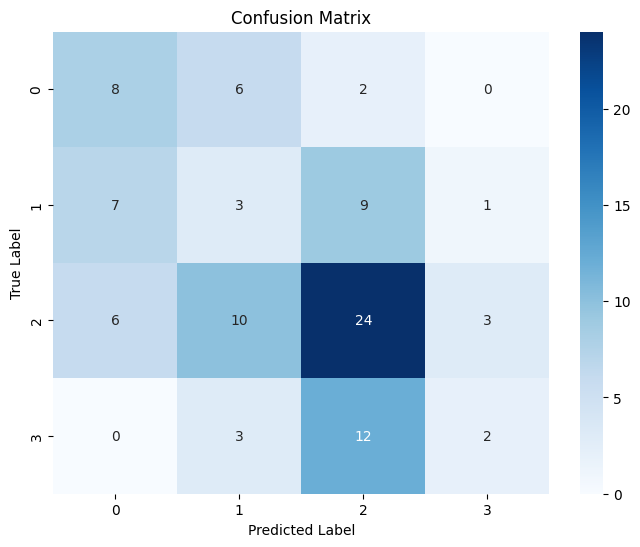

In [59]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [60]:
# Misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]

print("Misclassified Sentences:")
for idx in misclassified_indices:
    print(f"True Label: {y_test.iloc[idx]}, Predicted Label: {y_pred[idx]}, Sentence: {X_test.iloc[idx]}")

Misclassified Sentences:
True Label: 3, Predicted Label: 2, Sentence: From symbol of peace to megaphone for war, #Putin rewrites history of #Luzniki stadium
True Label: 1, Predicted Label: 2, Sentence: Countries supporting #Ukraine do not have the means to track the weapons they send to the Kiev army. And some have already gone to pro-Russian troops in the #Donbass, as some photos show 👇

by @FuturaDaprile

 
True Label: 1, Predicted Label: 0, Sentence: LA #GUERRA GIUSTA NON ESISTE!
INVOCARE #PACE INVIANDO #ARMI NON È PER L'EROE CHE COMBATTE, MA PER IL POPOLO CHE VIENE MACELLATO!
SIAMO UN PAESE DI COGLIONI INVASATI!
Sveglia!!!
#StopTheWar
#DraghiVatteneSubito
#NonInMioNome
True Label: 2, Predicted Label: 1, Sentence: This #April25 I will go to the parade.
I had the honor of knowing that generation of #Liberals who took up arms to defend the Fatherland, and I know they would have no problem today recognizing the #partisans of that time in the Ukrainians and Ukrainians of today.
 
True L

In [61]:
def generate_word_embeddings(text, tokenizer, model, device='cpu'):
    model.to(device)
    model.eval()
    
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model.bert(**inputs)  # Use the BERT backbone
        hidden_states = outputs.last_hidden_state  # Shape: (1, num_tokens, 768)
        embeddings = hidden_states.squeeze(0).cpu().numpy()  # Shape: (num_tokens, 768)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    return tokens, embeddings

In [62]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_word_embeddings(tokens, embeddings, reduction_method='pca'):
    # Step 1: Reduce dimensions to 2D
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(5, len(tokens) - 1))
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    else:
        raise ValueError("Invalid reduction method. Choose 'pca' or 'tsne'.")

    # Step 2: Plot the embeddings
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', alpha=0.7)

    # Annotate each point with its token
    for i, token in enumerate(tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)

    plt.xlabel(f'{reduction_method.upper()} Component 1')
    plt.ylabel(f'{reduction_method.upper()} Component 2')
    plt.title(f'2D Word Embedding Visualization ({reduction_method.upper()})')
    plt.grid()
    plt.show()

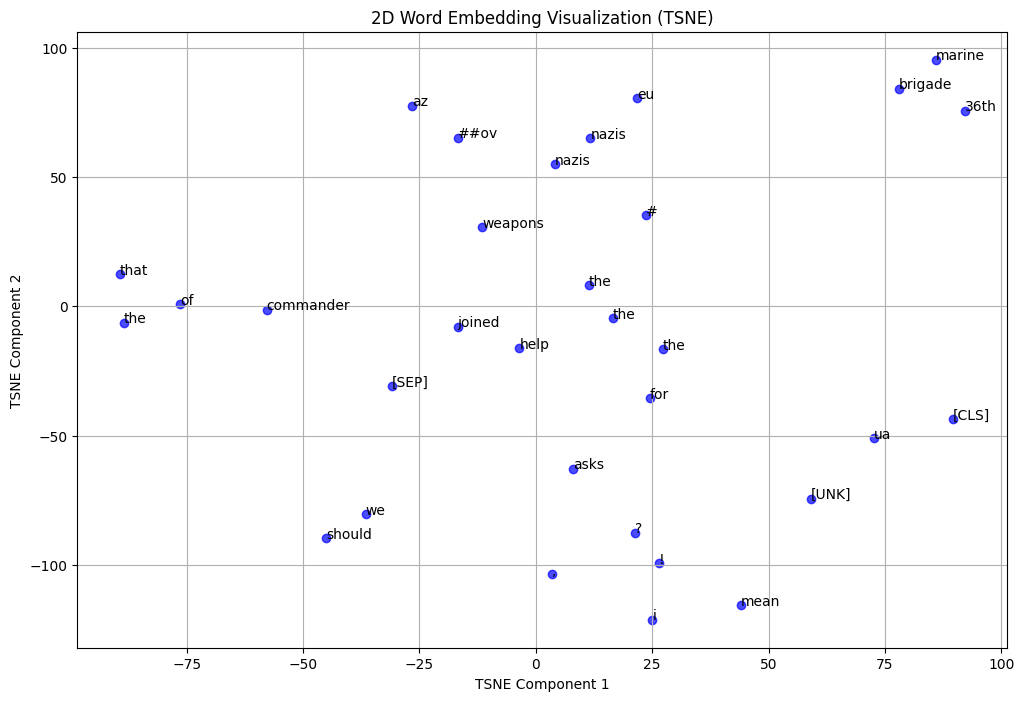

In [64]:
# Example sentence
sentence = """UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""

# Generate word embeddings
tokens, embeddings = generate_word_embeddings(sentence, tokenizer, hyperparam_finetuned_model, device=device)

# Plot embeddings
plot_word_embeddings(tokens, embeddings, reduction_method='tsne')  # Use 'pca' or 'tsne'

In [65]:
def plot_attention_scores(sentence, tokenizer, model, device='cpu', layer=0, head=0):
    model.to(device)
    model.eval()

    # Tokenize the input sentence
    inputs = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate attention scores
    with torch.no_grad():
        outputs = model.bert(**inputs, output_attentions=True)
        attentions = outputs.attentions  # Tuple of attention tensors for all layers and heads

    # Extract attention scores for the specified layer and head
    attention_scores = attentions[layer][0, head].cpu().numpy()  # Shape: (num_tokens, num_tokens)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Plot attention scores as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_scores, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f"Attention Scores (Layer {layer}, Head {head})")
    plt.xlabel("Keys (Tokens)")
    plt.ylabel("Queries (Tokens)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

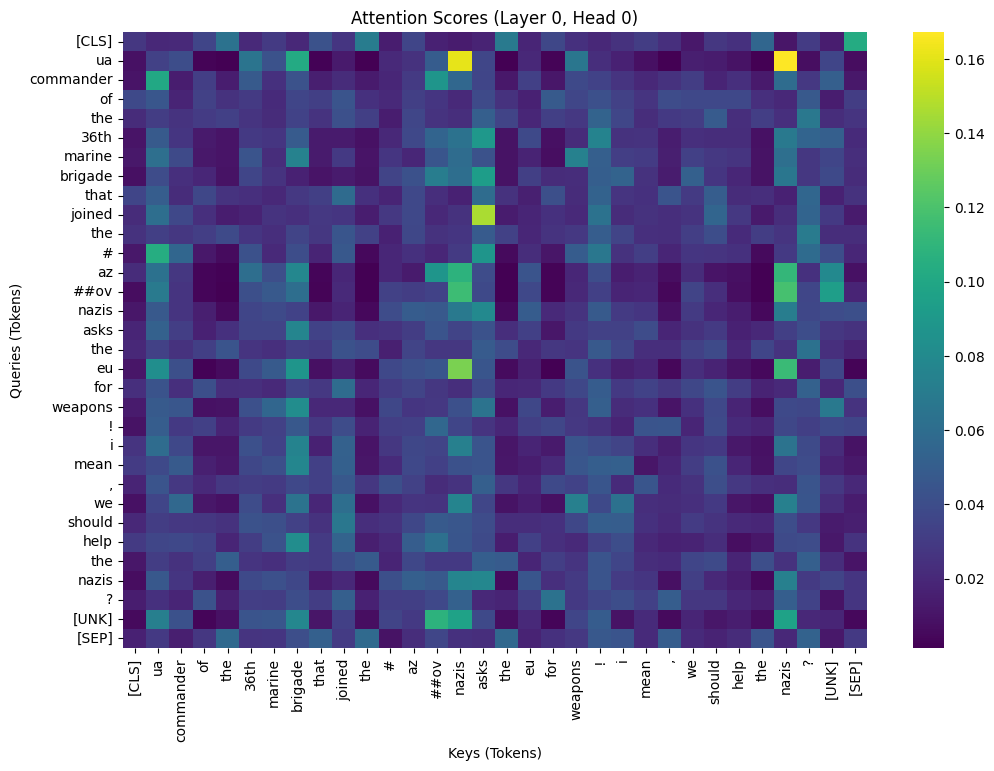

In [66]:
# Example sentence
sentence = """UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""
# Plot attention scores for Layer 0, Head 0
plot_attention_scores(sentence, tokenizer, hyperparam_finetuned_model, device=device, layer=0, head=0)

# Hyper Param + Validation

In [4]:
import numpy as np
import pandas as pd
import torch
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import shap

In [3]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=4b34ce0e077ea0b4343b16664013dd4743c363d89a66c8b51fe0d01eaa2451aa
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [5]:
# Load data
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')
X = data['Translated']
y = data['Label']

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)), output_attentions=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
# Define dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=self.max_length
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val.tolist(), y_val.tolist(), tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
# Fine-tune BERT with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, scheduler, patience=3, epochs=25):
    best_val_loss = float('inf')
    patience_counter = 0
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        model.train()

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

print("Fine-tuning BERT with early stopping...")
train_model_with_early_stopping(model, train_loader, val_loader, optimizer, scheduler, patience=3, epochs=25)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


Fine-tuning BERT with early stopping...


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1, Loss: 1.406966629482451, Val Loss: 1.4369511604309082
Epoch 2, Loss: 1.4039650701341175, Val Loss: 1.4369511604309082
Epoch 3, Loss: 1.398020659174238, Val Loss: 1.4369511604309082
Epoch 4, Loss: 1.4023682844071161, Val Loss: 1.4369511604309082
Early stopping triggered.


In [8]:
# Generate embeddings from fine-tuned BERT
def generate_finetuned_embeddings(texts, tokenizer, model, batch_size=32):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            ).to(device)
            outputs = model.bert(**inputs)  # Use the BERT backbone
            pooled_output = outputs.pooler_output.cpu().numpy()
            embeddings.append(pooled_output)
    return np.vstack(embeddings)

print("Generating embeddings...")
X_train_embeddings = generate_finetuned_embeddings(X_train.tolist(), tokenizer, model)
X_val_embeddings = generate_finetuned_embeddings(X_val.tolist(), tokenizer, model)
X_test_embeddings = generate_finetuned_embeddings(X_test.tolist(), tokenizer, model)

# Handle class imbalance using class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Generating embeddings...


Training basic SVM...
Accuracy: 30.56%
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.38      0.36        13
           1       0.07      0.06      0.06        18
           2       0.40      0.47      0.43        30
           3       0.25      0.18      0.21        11

    accuracy                           0.31        72
   macro avg       0.26      0.27      0.27        72
weighted avg       0.28      0.31      0.29        72



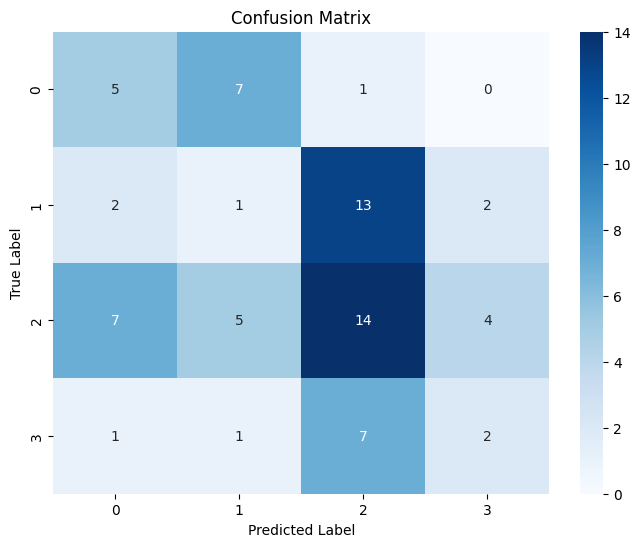

In [9]:
print("Training basic SVM...")
clf = SVC(kernel='linear')  # Simple linear kernel
clf.fit(X_train_embeddings, y_train)

# Evaluate SVM
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Tuning Again

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')
X = data['Translated']
y = data['Label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)), output_attentions=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [2]:
# Define dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=self.max_length
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [3]:
# Fine-tune BERT (basic training loop)
def train_model(model, train_loader, optimizer, scheduler, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

print("Fine-tuning BERT...")
train_model(model, train_loader, optimizer, scheduler, epochs=25)  # Fewer epochs for simplicity

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fine-tuning BERT...


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1, Loss: 1.3278631667296092
Epoch 2, Loss: 1.3245292901992798
Epoch 3, Loss: 1.3188520148396492
Epoch 4, Loss: 1.3225685159365337
Epoch 5, Loss: 1.3152215083440144
Epoch 6, Loss: 1.3194041127959888
Epoch 7, Loss: 1.3189118554194768
Epoch 8, Loss: 1.3258318901062012
Epoch 9, Loss: 1.3255696843067806
Epoch 10, Loss: 1.3253994211554527
Epoch 11, Loss: 1.3220394402742386
Epoch 12, Loss: 1.3207699954509735
Epoch 13, Loss: 1.3315373361110687
Epoch 14, Loss: 1.3143953929344814
Epoch 15, Loss: 1.3157233248154323
Epoch 16, Loss: 1.3122547914584477
Epoch 17, Loss: 1.3185652544101079
Epoch 18, Loss: 1.3284781177838643
Epoch 19, Loss: 1.3183008208870888
Epoch 20, Loss: 1.3140487720568974
Epoch 21, Loss: 1.329940175016721
Epoch 22, Loss: 1.3273509045441945
Epoch 23, Loss: 1.3160165150960286
Epoch 24, Loss: 1.3213482896486919
Epoch 25, Loss: 1.3152916878461838


In [4]:
# Generate embeddings from fine-tuned BERT
def generate_finetuned_embeddings(texts, tokenizer, model, batch_size=32):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            ).to(device)
            outputs = model.bert(**inputs)  # Use the BERT backbone
            pooled_output = outputs.pooler_output.cpu().numpy()
            embeddings.append(pooled_output)
    return np.vstack(embeddings)

print("Generating embeddings...")
X_train_embeddings = generate_finetuned_embeddings(X_train.tolist(), tokenizer, model)
X_test_embeddings = generate_finetuned_embeddings(X_test.tolist(), tokenizer, model)

Generating embeddings...


Training basic SVM...
Accuracy: 42.71%
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.50      0.46        16
           1       0.20      0.20      0.20        20
           2       0.53      0.63      0.57        43
           3       0.33      0.12      0.17        17

    accuracy                           0.43        96
   macro avg       0.37      0.36      0.35        96
weighted avg       0.41      0.43      0.41        96



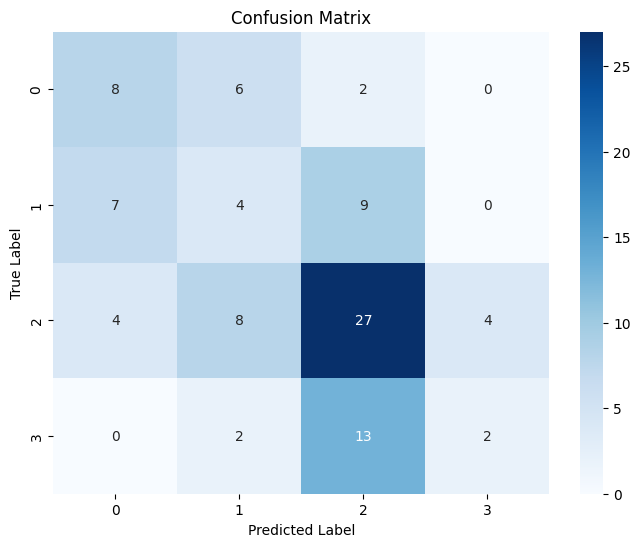

In [5]:
# Train a basic SVM classifier
print("Training basic SVM...")
clf = SVC(kernel='linear')  # Simple linear kernel
clf.fit(X_train_embeddings, y_train)

# Evaluate SVM
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [6]:
# Misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]
print("Misclassified Sentences:")
for idx in misclassified_indices:
    print(f"True Label: {y_test.iloc[idx]}, Predicted Label: {y_pred[idx]}, Sentence: {X_test.iloc[idx]}")

Misclassified Sentences:
True Label: 3, Predicted Label: 2, Sentence: From symbol of peace to megaphone for war, #Putin rewrites history of #Luzniki stadium
True Label: 1, Predicted Label: 2, Sentence: Countries supporting #Ukraine do not have the means to track the weapons they send to the Kiev army. And some have already gone to pro-Russian troops in the #Donbass, as some photos show 👇

by @FuturaDaprile

 
True Label: 1, Predicted Label: 0, Sentence: LA #GUERRA GIUSTA NON ESISTE!
INVOCARE #PACE INVIANDO #ARMI NON È PER L'EROE CHE COMBATTE, MA PER IL POPOLO CHE VIENE MACELLATO!
SIAMO UN PAESE DI COGLIONI INVASATI!
Sveglia!!!
#StopTheWar
#DraghiVatteneSubito
#NonInMioNome
True Label: 2, Predicted Label: 0, Sentence: This #April25 I will go to the parade.
I had the honor of knowing that generation of #Liberals who took up arms to defend the Fatherland, and I know they would have no problem today recognizing the #partisans of that time in the Ukrainians and Ukrainians of today.
 
True L

In [7]:
def generate_word_embeddings(text, tokenizer, model, device='cpu'):
    model.to(device)
    model.eval()
    
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model.bert(**inputs)  # Use the BERT backbone
        hidden_states = outputs.last_hidden_state  # Shape: (1, num_tokens, 768)
        embeddings = hidden_states.squeeze(0).cpu().numpy()  # Shape: (num_tokens, 768)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    return tokens, embeddings

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_word_embeddings(tokens, embeddings, reduction_method='pca'):
    # Step 1: Reduce dimensions to 2D
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(5, len(tokens) - 1))
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    else:
        raise ValueError("Invalid reduction method. Choose 'pca' or 'tsne'.")

    # Step 2: Plot the embeddings
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', alpha=0.7)

    # Annotate each point with its token
    for i, token in enumerate(tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)

    plt.xlabel(f'{reduction_method.upper()} Component 1')
    plt.ylabel(f'{reduction_method.upper()} Component 2')
    plt.title(f'2D Word Embedding Visualization ({reduction_method.upper()})')
    plt.grid()
    plt.show()

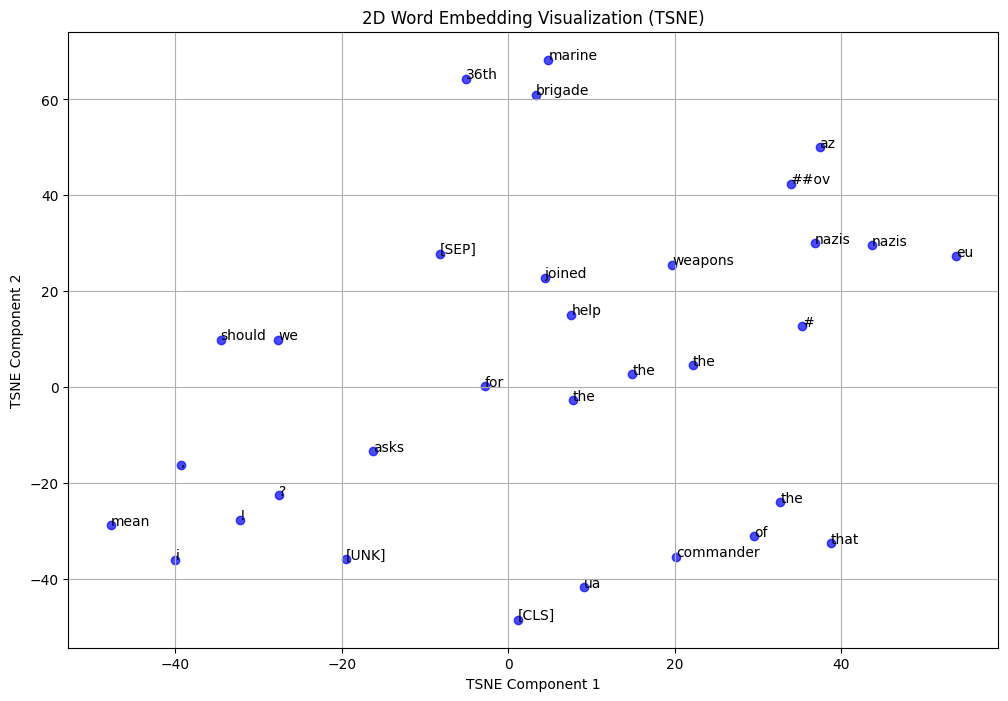

In [9]:
# Example sentence
sentence = """UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""

# Generate word embeddings
tokens, embeddings = generate_word_embeddings(sentence, tokenizer, model, device=device)

# Plot embeddings
plot_word_embeddings(tokens, embeddings, reduction_method='tsne')  # Use 'pca' or 'tsne'

In [10]:
def plot_attention_scores(sentence, tokenizer, model, device='cpu', layer=0, head=0):
    model.to(device)
    model.eval()

    # Tokenize the input sentence
    inputs = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate attention scores
    with torch.no_grad():
        outputs = model.bert(**inputs, output_attentions=True)
        attentions = outputs.attentions  # Tuple of attention tensors for all layers and heads

    # Extract attention scores for the specified layer and head
    attention_scores = attentions[layer][0, head].cpu().numpy()  # Shape: (num_tokens, num_tokens)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Plot attention scores as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_scores, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f"Attention Scores (Layer {layer}, Head {head})")
    plt.xlabel("Keys (Tokens)")
    plt.ylabel("Queries (Tokens)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

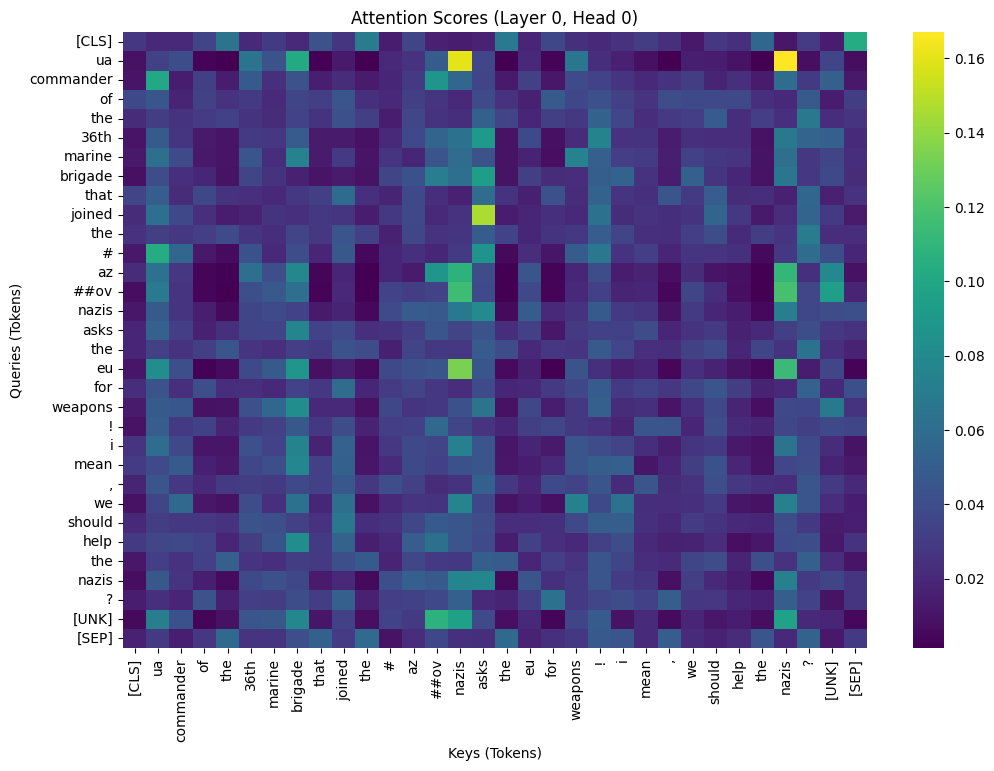

In [11]:
# Example sentence
sentence = """UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""
# Plot attention scores for Layer 0, Head 0
plot_attention_scores(sentence, tokenizer, model, device=device, layer=0, head=0)